# **Oil Palm Production Prediction: Machine Learning Approach**

by Lau Wen Jun

# Table of Contents
1. [Background](#1.-Background)
2. [Variables](#2.-Variables)
3. [Data Preprocessing](#3.-Data-Prerocessing)
    - 3.1. [Data Loading & Setup](#3.1.-Data-Loading-&-Setup)
    - 3.2. [Handing Missing Values](#3.2.-Handing-Missing-Values)
    - 3.3. [Feature Engineering](#3.3.-Feature-Engineering)
    - 3.4. [Feature Scaling](#3.4.-Feature-Scaling)
    - 3.5. [Train & Test Split](#3.5.-Train-&-Test-Split)
    - 3.6. [Feature Selection](#3.6.-Feature-Selection)
4. [Model Development & Forecasting](#4.-Model-Development-&-Forecasting) 
    - 4.1. [Model Selection & Performance Evaluation](#4.1.-Model-Selection-&-Performance-Evaluation) 
      - 4.1.1. [Machine Learning Models](#4.1.1.-Machine-Learning-Models) 
      - 4.1.2. [Performance Metrics](#4.1.2.-Performance-Metrics) 
      - 4.1.3. [Best Model Selection](#4.1.3.-Best-Model-Selection) 
    - 4.2. [Hyperparameter Tuning](#4.2.-Hyperparameter-Tuning) 
      - 4.2.1. [Key Hyperparameters](#4.2.1.-Key-Hyperparameters) 
      - 4.2.2. [Final Model Selection: Tuned vs. Untuned](#4.2.2.-Final-Model-Selection:-Tuned-vs.-Untuned) 
    - 4.3. [Future Predictions for Oil Palm Production (Jan-Mar 2024)](#4.3.-Future-Predictions-for-Oil-Palm-Production (Jan-Mar 2024)) 
5. [Conclusion](#5.-Conclusion)
    - 5.1. [Key Findings](#5.1.-Key-Findings)
    - 5.2. [Recommendations](#5.2.-Recommendations)
    - 5.3. [Limitations](#5.3.-Limitations)

## [1. Background](#Table-of-Contents)

Oil palm plantations play a critical role in the agricultural sector, providing a major source of palm oil, which is used in food production, cosmetics, and biofuel. Accurate forecasting of oil palm production is essential for efficient resource management, supply chain planning, and decision-making.

The yield of oil palm trees is influenced by various factors, including **seasonality, growth stages, plantation size, fertilizer application, and environmental conditions**. Given the biological nature of oil palm trees, production patterns follow well-defined cycles:

- **Yearly seasonality** impacts fruiting patterns.
- **Palm tree growth stages** determine productivity, with an increase in production up to a peak before a decline with aging.
- **Fertilizer application** influences yield over a long period, with effects lasting up to 24 months.
- **Rainfall variability** can either enhance or negatively impact production, particularly when extreme conditions persist.

With these factors in mind, a predictive model is developed to estimate monthly oil palm production for **January, February, and March 2024** using historical data from **January 2013 to December 2023**. The goal is to provide stakeholders with a reliable forecasting tool to support operational planning and optimize agricultural output.

## [2. Variables](#Table-of-Contents)

The dataset consists of various features that influence monthly oil palm production. Below is a breakdown of the selected variables used in the model:

## ***Target Variable***
- **Production** (metric tonnes): The monthly production of oil palm fruit, which the model aims to predict.

## ***Predictor Variables***

**Time-Based Features**
- **Year**: Extracted from the date to capture long-term trends.
- **Month**: Extracted from the date to capture seasonality effects.

**Palm Growth & Plantation Features**
- **Age** (years): The age of the oil palm tree, which significantly affects production.
- **PalmDensity** (palms/hectare): The density of oil palm trees in a given plantation area.

**Growth Stage Features (One-Hot Encoded)**
- **GrowthStage_Optima**l (binary: 0/1): Indicates if the palm is in the optimal production stage (9-15 years).
- **GrowthStage_Plateauing** (binary: 0/1): Indicates if the palm is in the plateauing production stage (16-20 years).

**Environmental & Climatic Features**
- **Rainday_rolling_24** (days): 24-month rolling average of rainy days.
- **Rainfall_rolling_24** (mm): 24-month rolling average of rainfall.
- **Rainfall_Lag_12, Rainfall_Lag_24** (mm): Rainfall amount recorded 12 and 24 months prior, as past rainfall influences production.
- **Rainfall_extreme_deficit** (binary: 0/1): A flag indicating whether rainfall was below 100mm for three consecutive months.
- **Rainfall_extreme_excess** (binary: 0/1): A flag indicating whether rainfall was above 300mm for three consecutive months.

**Fertilizer Application Features**
- **Fertilizer** (kg/palm): The amount of fertilizer applied per palm tree.
- **Fertilizer_Lag_12, Fertilizer_Lag_24** (kg/palm): The amount of fertilizer applied 12 and 24 months prior, as fertilizer has long-term effects.

**Production History Features**
- **Production_rolling_36** (metric tonnes): 36-month rolling average of production.
- **Production_lag_12, Production_lag_24, Production_lag_36** (metric tonnes): The production recorded 12, 24 and 36 months prior, considering the three-year fruiting cycle.


# [3. Data Preprocessing](#Table-of-Contents)

## [3.1. Data Loading & Setup](#Table-of-Contents)

The dataset is loaded from an Excel file containing **132 rows and 8 columns**, representing monthly oil palm production data. Key Python libraries such as **pandas, NumPy, scikit-learn, and XGBoost** are imported for data preprocessing, feature engineering, model training, and evaluation. Warnings are suppressed to ensure a clean output.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
import warnings

In [12]:
# Suppress warnings
warnings.filterwarnings('ignore')

In [13]:
# Load the dataset
file_path = r"C:\Users\Jun\Downloads\Data Scientist Technical Assessment Dataset 1.xlsx"
xls = pd.ExcelFile(file_path)
df = pd.read_excel(xls, sheet_name="Sheet1")
df.shape

(132, 8)

## [3.2. Handing Missing Values](#Table-of-Contents)

The dataset was checked for missing values.
Missing values in **Rainfall** and **Rainday** were imputed using the **median**, assuming extreme values could affect production, but missing values should be replaced with a reasonable central tendency.

In [16]:
# Check for null values in the dataset
df.isnull().sum() [df.isnull().sum() > 0]

Rainfall    2
Rainday     3
dtype: int64

In [17]:
# Fill missing values using the median
df["Rainfall"] = df["Rainfall"].fillna(df["Rainfall"].median())
df["Rainday"] = df["Rainday"].fillna(df["Rainday"].median())

## [3.3. Feature Engineering](#Table-of-Contents)

Feature engineering involves creating meaningful transformations from raw data to improve model performance. **Time-based features** such as **Year** and **Month** were extracted from the **Date** column to capture seasonality and long-term trends. **Lag features** were created for **Rainfall (12, 24 months)**, **Fertilizer (12, 24 months)**, and **Production (12, 24, 36 months)** to account for delayed effects on yield. To address extreme weather impacts, binary indicators were introduced for **Rainfall Deficit (<100mm for 3 consecutive months)** and **Rainfall Excess (>300mm for 3 consecutive months)**. Additionally, **rolling mean features** were computed for **Rainfall, Fertilizer, and Rainday (24 months)**, along with **Production (36 months)** to smooth fluctuations and capture longer-term trends affecting oil palm production. These rolling averages help mitigate short-term variability and highlight sustained effects of environmental factors. 

**Growth stage categorization** was applied based on palm tree age, with trees classified into **No Production, Low Increasing, Optimal, Plateauing, and Declining** phases. One-hot encoding was used for growth stages to improve model interpretability. Since **Palm Stand and Area** are redundant, **Palm Density (Palm Stand/Area)** was computed to represent plantation density more effectively. To ensure consistency, **rows with missing values due to lag features were removed**, finalizing the dataset for modeling.

In [20]:
# Convert Date column to datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Extract time-based features
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

# Create rolling mean features for rainday, rainfall and fertilizer (24 months)
# df["Rainday_rolling_12"] = df["Rainday"].rolling(window=12).mean()
df["Rainday_rolling_24"] = df["Rainday"].rolling(window=24).mean()
# df["Rainfall_rolling_12"] = df["Rainfall"].rolling(window=12).mean()
df["Rainfall_rolling_24"] = df["Rainfall"].rolling(window=24).mean()
# df["Fertilizer_rolling_12"] = df["Fertilizer"].rolling(window=12).mean()
df["Fertilizer_rolling_24"] = df["Fertilizer"].rolling(window=24).mean()

# Create rolling mean feature for production (36 months)
# df["Production_rolling_12"] = df["Production"].rolling(window=12).mean()
# df["Production_rolling_24"] = df["Production"].rolling(window=24).mean()
df["Production_rolling_36"] = df["Production"].rolling(window=36).mean()

# # Create selected lag features for Rainfall and Fertilizer
# df["Rainfall_Lag_1"] = df["Rainfall"].shift(1)
# df["Rainfall_Lag_3"] = df["Rainfall"].shift(3)
# df["Rainfall_Lag_6"] = df["Rainfall"].shift(6)
df["Rainfall_Lag_12"] = df["Rainfall"].shift(12)
# df["Rainfall_Lag_18"] = df["Rainfall"].shift(18)
df["Rainfall_Lag_24"] = df["Rainfall"].shift(24)
# df["Fertilizer_Lag_1"] = df["Fertilizer"].shift(1)
# df["Fertilizer_Lag_3"] = df["Fertilizer"].shift(3)
# df["Fertilizer_Lag_6"] = df["Fertilizer"].shift(6)
df["Fertilizer_Lag_12"] = df["Fertilizer"].shift(12)
# df["Fertilizer_Lag_18"] = df["Fertilizer"].shift(18)
df["Fertilizer_Lag_24"] = df["Fertilizer"].shift(24)

# # Create selected lag features for Production
# df["Production_lag_1"] = df["Production"].shift(1)
# df["Production_lag_3"] = df["Production"].shift(3)
# df["Production_lag_6"] = df["Production"].shift(6)
df["Production_lag_12"] = df["Production"].shift(12)
# df["Production_lag_18"] = df["Production"].shift(18)
df["Production_lag_24"] = df["Production"].shift(24)
df["Production_lag_36"] = df["Production"].shift(36)

# Check for extreme rainfall conditions (as per requirements)
df['Rainfall_extreme_deficit'] = (df['Rainfall'].rolling(window=3).sum() < 100).astype(int)
df['Rainfall_extreme_excess'] = (df['Rainfall'].rolling(window=3).sum() > 300).astype(int)

# Create growth stage features based on domain knowledge
def get_growth_stage(age):
    if age <= 3:
        return 'No Production'
    elif age <= 8:
        return 'Low Increasing'
    elif age <= 15:
        return 'Optimal'
    elif age <= 20:
        return 'Plateauing'
    else:
        return 'Declining'

df['GrowthStage'] = df['Age'].apply(get_growth_stage)

# Create dummy variables for growth stages
df = pd.get_dummies(df, columns=['GrowthStage'], drop_first=True)

# Calculate palm density (palms per hectare)
df['PalmDensity'] = df['Palm Stand'] / df['Area']

# Drop rows with NaN values caused by shifting
df.dropna(inplace=True)


## [3.4. Feature Scaling](#Table-of-Contents)

To ensure consistency in feature magnitudes and improve model performance, **MinMaxScaler** was applied to selected numerical variables. This transformation scales the values between **0 and 1**, preserving their relative differences while preventing any single feature from dominating the model due to larger numerical ranges.

The selected features for scaling include **Age, Rainfall, Fertilizer, Rainday, Lagged Rainfall and Fertilizer (12 and 24 months), Lagged Production (12, 24, and 36 months), Rolling Mean of Rainfall, Fertilizer, Rainday (24 months), Rolling Mean of Production (36 months), Extreme Rainfall Indicators, and Palm Density.** These variables were chosen based on their continuous nature and impact on production. Feature scaling helps enhance model stability, improves optimization efficiency, and ensures fair weight distribution across all input variables.

In [23]:
# # Apply MinMaxScaler to selected features
scaler = MinMaxScaler()
scaled_features = ['Age', 'Rainfall', 'Fertilizer', 'Rainday', 'Production_lag_12', 'Rainfall_Lag_12', 'Fertilizer_Lag_12', 'Production_lag_24', 'Rainfall_Lag_24', 'Fertilizer_Lag_24', 'Production_lag_36','Fertilizer_rolling_24', 'Rainday_rolling_24','Rainfall_rolling_24', 'Production_rolling_36', 'Rainfall_extreme_deficit', 'Rainfall_extreme_excess', 'PalmDensity']
df[scaled_features] = scaler.fit_transform(df[scaled_features])

## [3.5. Train & Test Split](#Table-of-Contents)

The dataset is split into **training (80%) and testing (20%)** sets to assess the model's performance. Since this is a time-series problem, the data is split chronologically **(shuffle=False)** to prevent data leakage. The target variable is **"Production"**, while non-informative variables such as **"Date," "Rainfall," "Fertilizer," "Rainday," "GrowthStage," "Palm Stand," and "Area"** are excluded to focus on derived and relevant predictive features. This structured approach ensures that the model learns from past data and generalizes effectively for future predictions.

In [26]:
# Define features and target variable
target = "Production"
features = [col for col in df.columns if col not in ["Date", "Rainfall", "Fertilizer", "Production", "Rainday", "GrowthStage", "Palm Stand", "Area"]]

In [27]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42, shuffle=False)

## [3.6. Feature Selection](#Table-of-Contents)

Feature selection enhances model efficiency by removing less relevant variables while preserving predictive power. **Random Forest** was used to compute feature importance, followed by **Recursive Feature Elimination (RFE)** to retain the most impactful predictors. **Cross-validation** determined the optimal number of features (N) for improved performance.

The final model was trained on the top five selected features. **Month** emerged as the strongest predictor, reflecting seasonal production trends. **Production_rolling_36** and **Production_lag_36** confirm the significance of the **three-year production cycle**. **Rainday_rolling_24** and **Rainfall_Lag_12** highlight the influence of **rainfall patterns** on production. These features, refined through RFE and cross-validation, ensure model reliability while eliminating redundancy.

Optimal N: 5 with RMSE: 5.7071
Selected Features after RFE: ['Month', 'Production_lag_36', 'Production_rolling_36', 'Rainfall_Lag_12', 'Rainday_rolling_24']


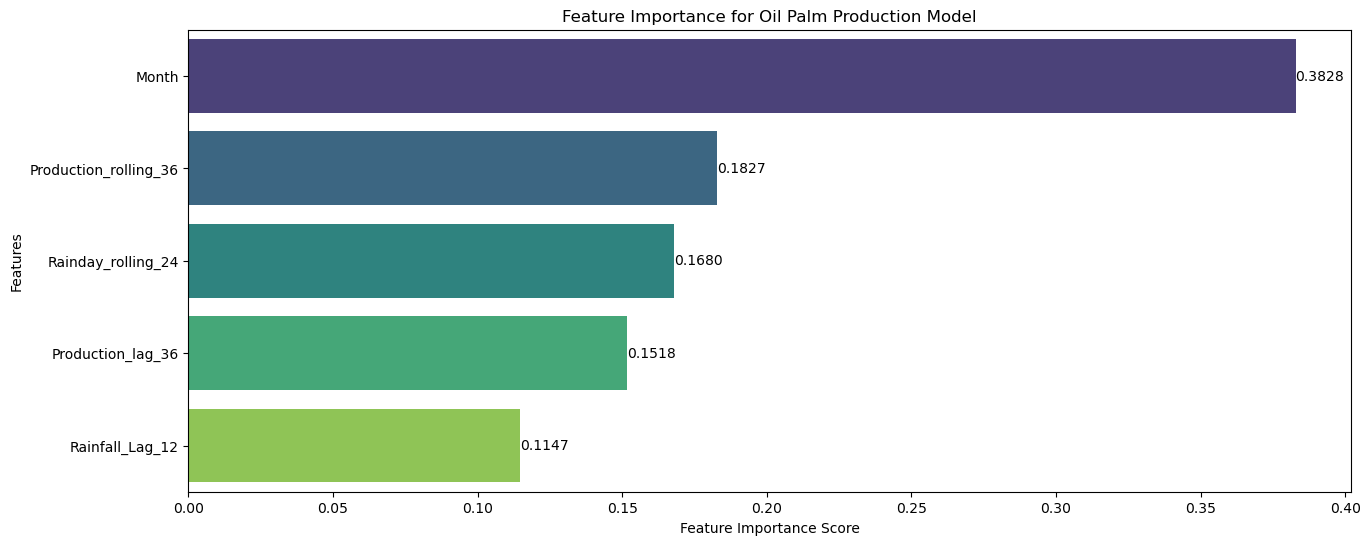

In [30]:
# Feature Importance using Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
feature_importance = pd.DataFrame({'Feature': features, 'Importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Find the best N using cross-validation
N_values = range(5, len(feature_importance), 5)  # Test in steps of 5
best_N = None
best_rmse = float("inf")

for N in N_values:
    selected_features = feature_importance.iloc[:N]['Feature'].tolist()
    
    # Train and evaluate model with selected features
    rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
    scores = cross_val_score(rf_temp, X_train[selected_features], y_train, 
                             cv=5, scoring="neg_root_mean_squared_error")  
    mean_rmse = -scores.mean()  # Convert negative RMSE to positive
    
    # Keep track of best N
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_N = N

print(f"Optimal N: {best_N} with RMSE: {best_rmse:.4f}")

# Select the top best_N features
selected_features = feature_importance.iloc[:best_N]['Feature'].tolist()

# Apply Recursive Feature Elimination (RFE) on the selected features
rfe_model = RandomForestRegressor(n_estimators=100, random_state=42)
rfe = RFE(estimator=rfe_model, n_features_to_select=best_N) 
rfe.fit(X_train[selected_features], y_train)
selected_rfe_features = [feature for feature, selected in zip(selected_features, rfe.support_) if selected]

# Final feature set
final_features = selected_rfe_features
X_train = X_train[final_features]
X_test = X_test[final_features]

print("Selected Features after RFE:", final_features)

# Retrain Random Forest on selected features
rf_final = RandomForestRegressor(n_estimators=100, random_state=42)
rf_final.fit(X_train, y_train)  # Train using only selected features

# Extract feature importance for the selected features
feature_importances = pd.DataFrame({
    'Feature': final_features,  
    'Importance': rf_final.feature_importances_ 
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(15, 6))
sns.barplot(x=feature_importances["Importance"], y=feature_importances["Feature"], palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance for Oil Palm Production Model")

# Annotate values on bars
for index, value in enumerate(feature_importances["Importance"]):
    plt.text(value, index, f"{value:.4f}", va='center')

plt.show()

## [4. Model Development & Forecasting](#Table-of-Contents)

### [4.1. Model Selection & Performance Evaluation](#Table-of-Contents)

To identify the best predictive model for oil palm production, multiple machine learning algorithms were tested, including **Linear Regression, Random Forest, Gradient Boosting, and XGBoost**. Each model was trained on the **training dataset (80%)** and evaluated on the **testing dataset (20%)** to measure its predictive accuracy.

#### [4.1.1. Machine Learning Models](#Table-of-Contents)

**Linear Regression**

Linear Regression is a statistical model that assumes a **linear relationship** between independent variables (features) and the dependent variable (production). It is used as a **baseline model** to understand whether a simple linear equation can explain variations in the target variable. It is easy to interpret and computationally efficient, making it useful for initial analysis.

**Random Forest**

Random Forest is an **ensemble learning method** that combines multiple **decision trees** to improve prediction accuracy and reduce overfitting. It is particularly useful for handling **non-linear relationships** and capturing complex patterns in the data. The model leverages **bootstrap aggregation (bagging)** to improve stability and generalization. It is chosen for its **robustness to outliers** and ability to handle high-dimensional datasets.

**Gradient Boosting**

Gradient Boosting is a **boosting algorithm** that builds trees sequentially, where each new tree focuses on correcting errors made by the previous trees. Unlike Random Forest, which trains trees independently, Gradient Boosting reduces bias by iteratively optimizing errors. It is **effective for structured datasets**, can capture **complex interactions**, and generally provides better performance than bagging methods like Random Forest.

**XGBoost (Extreme Gradient Boosting)**

XGBoost is an advanced version of Gradient Boosting designed for **speed, scalability, and regularization**. It incorporates **parallel processing, built-in cross-validation, and efficient handling of missing values**, making it more effective than standard Gradient Boosting. Widely used for structured data problems, XGBoost **optimizes training, reduces overfitting, and delivers high accuracy**, even with large datasets, while maintaining computational efficiency.

#### [4.1.2. Performance Metrics](#Table-of-Contents)

he models were evaluated using the following key metrics:

- **Root Mean Squared Error (RMSE)** – Measures prediction error magnitude.
- **Cross-Validation RMSE (CV_RMSE)** – Assesses model generalization on unseen data.
- **R² Score** – Indicates how well the model explains variance in production.
- **Mean Absolute Error (MAE)** – Evaluates the absolute prediction deviation.
- **Mean Absolute Percentage Error (MAPE)** – Measures error as a percentage of actual values.

In [38]:
# Train multiple models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    tscv = TimeSeriesSplit(n_splits=10)
    cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_scores.mean()
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2, "MAPE": mape, "CV_RMSE": cv_rmse}
    print(f"{name} - RMSE: {rmse:.4f}, CV_RMSE: {cv_rmse:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")

# Select best model (lowest RMSE)
best_model_name = min(results, key=lambda x: (results[x]["RMSE"], results[x]["CV_RMSE"]))
best_model = models[best_model_name]
print(f"Best model: {best_model_name}")

Linear Regression - RMSE: 4.5737, CV_RMSE: 6.5516, R2: 0.1909, MAE: 3.8342, MAPE: 0.2156
Random Forest - RMSE: 3.4947, CV_RMSE: 4.7739, R2: 0.5276, MAE: 2.7425, MAPE: 0.1404
Gradient Boosting - RMSE: 3.3806, CV_RMSE: 4.8362, R2: 0.5580, MAE: 2.6699, MAPE: 0.1403
XGBoost - RMSE: 3.3250, CV_RMSE: 4.4052, R2: 0.5724, MAE: 2.4847, MAPE: 0.1303
Best model: XGBoost


#### [4.1.3. Best Model Selection](#Table-of-Contents)


Among all models, **XGBoost** demonstrated the **lowest RMSE (3.3250) and highest R² score (0.5724)**, indicating strong predictive performance. It also achieved the **best cross-validation RMSE (4.4052)**, confirming its ability to generalize well to unseen data. 

**Gradient Boosting and Random Forest** followed closely, whereas **linear models** performed worse, struggling to capture complex relationships.

Thus, **XGBoost was selected as the final model** for predicting oil palm production due to **its superior accuracy, generalization ability, and robustness against overfitting**.

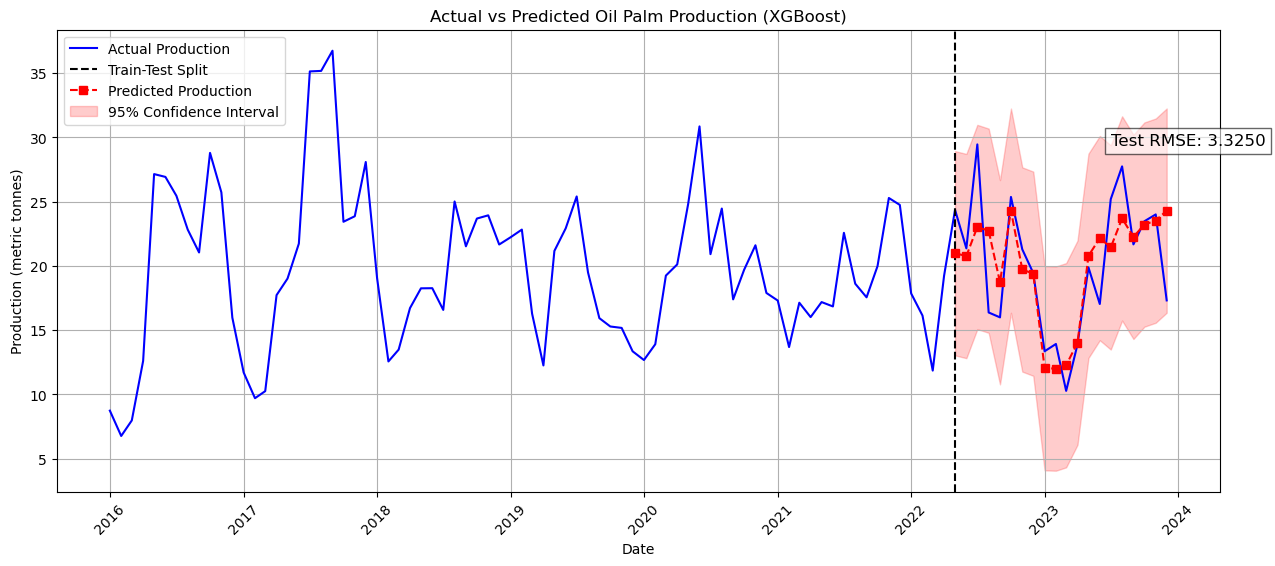

In [41]:
# Ensure sorted test set by date
X_test_sorted = X_test.copy()
X_test_sorted["Date"] = df.loc[X_test.index, "Date"]
X_test_sorted = X_test_sorted.sort_values("Date")

# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Production'], label="Actual Production", color='blue')
plt.axvline(x=X_test_sorted["Date"].min(), color='black', linestyle='--', label="Train-Test Split")
plt.plot(X_test_sorted["Date"], best_model.predict(X_test), label="Predicted Production", linestyle="dashed", marker="s", color='red')

# Confidence interval
preds = best_model.predict(X_test)
plt.fill_between(X_test_sorted["Date"], preds - 1.96 * np.std(preds), preds + 1.96 * np.std(preds), color='red', alpha=0.2, label="95% Confidence Interval")

# Annotate RMSE in the test area
plt.text(X_test_sorted["Date"].iloc[int(len(X_test_sorted) * 0.7)], 
         max(df['Production']) * 0.8, 
         f"Test RMSE: {results[best_model_name]['RMSE']:.4f}", 
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6))


plt.xlabel("Date")
plt.ylabel("Production (metric tonnes)")
plt.title(f"Actual vs Predicted Oil Palm Production ({best_model_name})")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

### [4.2. Hyperparameter Tuning](#Table-of-Contents)


Hyperparameter tuning optimizes model performance by adjusting key parameters. **RandomizedSearchCV** was used instead of **GridSearchCV** due to its efficiency in exploring a wide search space while reducing computational cost, making it ideal for small datasets. A total of **150 iterations** were performed to fine-tune **Random Forest, Gradient Boosting, and XGBoost.**

#### [4.2.1. Key Hyperparameters](#Table-of-Contents)

- **n_estimators:** Number of boosting rounds (trees), balancing bias and variance.
- **max_depth:** Limits tree depth to prevent overfitting while capturing complexity.
- **learning_rate:** Controls step size in updating weights, affecting model convergence.
- **colsample_bytree:** Fraction of features sampled per tree, improving generalization.
- **min_child_weight:** Minimum sum of instance weights per node, reducing overfitting in small datasets.

In [46]:
# Hyperparameter tuning for the best model
param_grid = {}
if best_model_name == "Random Forest":
    param_grid = {
        'n_estimators': [50, 100, 200],  
        'max_depth': [5, 10, 20],
        'min_samples_split': [5, 10, 15], 
        'min_samples_leaf': [2, 4, 6]
    }
elif best_model_name == "Gradient Boosting":
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.2, 0.3], 
        'max_depth': [3, 5, 7]
    }
elif best_model_name == "XGBoost":
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.2, 0.3], 
        'max_depth': [3, 5, 7],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'min_child_weight': [3, 5, 7]  
    }

# Perform Randomized Search for Hyperparameter Tuning
random_search = RandomizedSearchCV(
    best_model,
    param_distributions=param_grid,
    n_iter=150,  
    cv=3, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV to training data
random_search.fit(X_train, y_train)

# Get the best model from Randomized Search
best_tuned_model = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)

# Evaluate tuned model on test set
y_tuned_pred = best_tuned_model.predict(X_test)
tuned_rmse = mean_squared_error(y_test, y_tuned_pred, squared=False)

# Perform Cross-validation on tuned model
tscv = TimeSeriesSplit(n_splits=3)  # Adjust n_splits if needed
cv_scores_tuned = cross_val_score(best_tuned_model, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
tuned_cv_rmse = -cv_scores_tuned.mean()

# Compute additional evaluation metrics
tuned_r2 = r2_score(y_test, y_tuned_pred)
tuned_mae = mean_absolute_error(y_test, y_tuned_pred)
tuned_mape = mean_absolute_percentage_error(y_test, y_tuned_pred)

# Print evaluation results
print(f"Tuned Model - RMSE: {tuned_rmse:.4f}, CV_RMSE: {tuned_cv_rmse:.4f}, R²: {tuned_r2:.4f}, MAE: {tuned_mae:.4f}, MAPE: {tuned_mape:.4f}")

Best parameters: {'n_estimators': 50, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Tuned Model - RMSE: 3.3178, CV_RMSE: 5.7633, R²: 0.5742, MAE: 2.7205, MAPE: 0.1405


#### [4.2.2. Final Model Selection: Tuned vs. Untuned](#Table-of-Contents)

The **tuned XGBoost model** achieved a **slightly lower RMSE (3.3178 vs. 3.3250)**, justifying its selection. Although the improvement was minor, optimized hyperparameters enhance **stability and generalization** for future predictions.

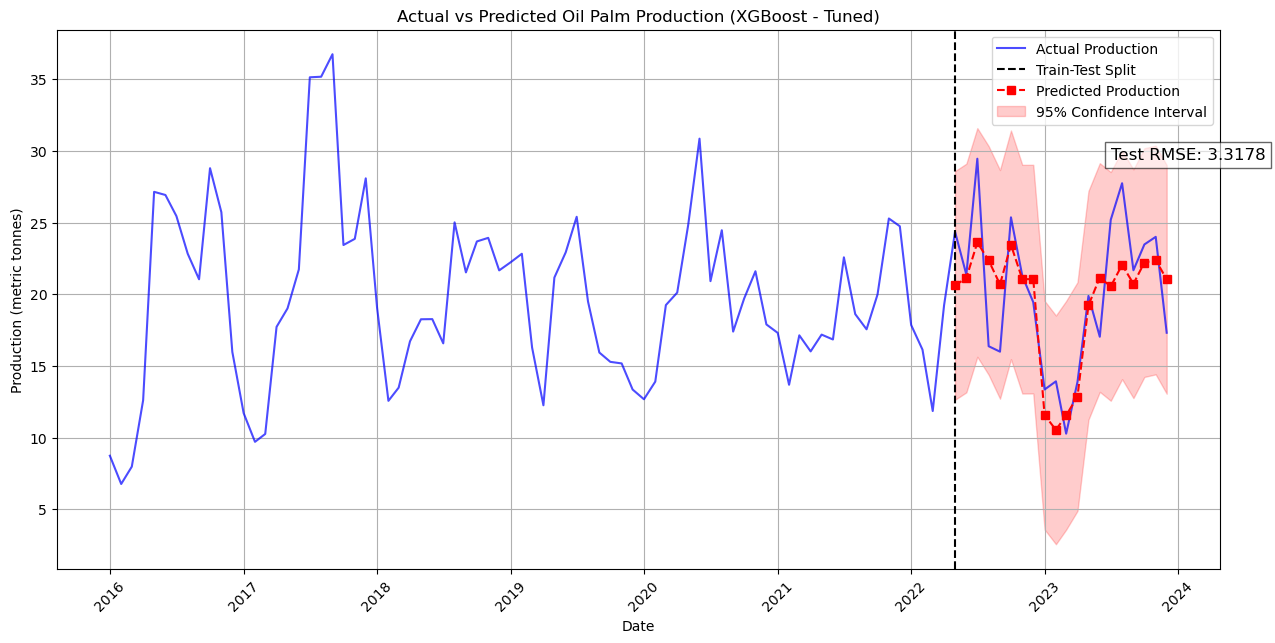

In [49]:
# Ensure sorted test set by date
X_test_sorted = X_test.copy()
X_test_sorted["Date"] = df.loc[X_test.index, "Date"]
X_test_sorted = X_test_sorted.sort_values("Date")

# Plot actual vs predicted values
plt.figure(figsize=(15, 7))
plt.plot(df['Date'], df['Production'], label="Actual Production", color='blue', alpha=0.7)
plt.axvline(x=X_test_sorted["Date"].min(), color='black', linestyle='--', label="Train-Test Split")
plt.plot(X_test_sorted["Date"], y_tuned_pred, label="Predicted Production", linestyle="dashed", marker="s", color='red')

# Confidence interval (95% interval)
ci = 1.96 * np.std(y_tuned_pred)
plt.fill_between(X_test_sorted["Date"], y_tuned_pred - ci, y_tuned_pred + ci, color='red', alpha=0.2, label="95% Confidence Interval")

# Annotate RMSE in the test area
plt.text(X_test_sorted["Date"].iloc[int(len(X_test_sorted) * 0.7)], 
         max(df['Production']) * 0.8, 
         f"Test RMSE: {tuned_rmse:.4f}", 
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Formatting
plt.xlabel("Date")
plt.ylabel("Production (metric tonnes)")
plt.title(f"Actual vs Predicted Oil Palm Production ({best_model_name} - Tuned)")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [50]:
# Compare tuned and untuned models, and select the best one
if tuned_rmse < results[best_model_name]["RMSE"]:
    best_model = best_tuned_model
    print(f"Use Tuned {best_model_name}")
else:
    print(f"Use Untuned {best_model_name}")

Use Tuned XGBoost


### [4.3. Future Predictions for Oil Palm Production (Jan-Mar 2024)](#Table-of-Contents)

To forecast oil palm production for **January, February, and March 2024**, the **best-performing tuned model (XGBoost)** was used. The most recent available data was leveraged to generate future predictions while maintaining consistency in feature engineering. **Time-based variables (Year and Month)** were extracted, and other feature values were carried forward from the last known observation.

The model predicted production values of **10.66, 9.95, and 9.95 metric tonnes**** for the three months, respectively. Additionally, **95% confidence intervals (CI)** were computed using the residual standard deviation from the training data. The lower and upper bounds provide an uncertainty range, indicating that actual production values are expected to fall within these intervals.

The visualization above integrates historical production data with predicted values, illustrating both the **trend and confidence intervals**. The **red dashed line** represents predictions, while the **shaded region** signifies the uncertainty in estimates. This approach ensures transparency in the model's forecasting capability and helps stakeholders make informed decisions.

Predicted Oil Palm Production for Jan-Mar 2024:
        Date  Predicted_Production  Lower_CI   Upper_CI
0 2024-01-01             10.664510  9.760344  11.568676
1 2024-02-01              9.948349  9.044183  10.852515
2 2024-03-01              9.948349  9.044183  10.852515


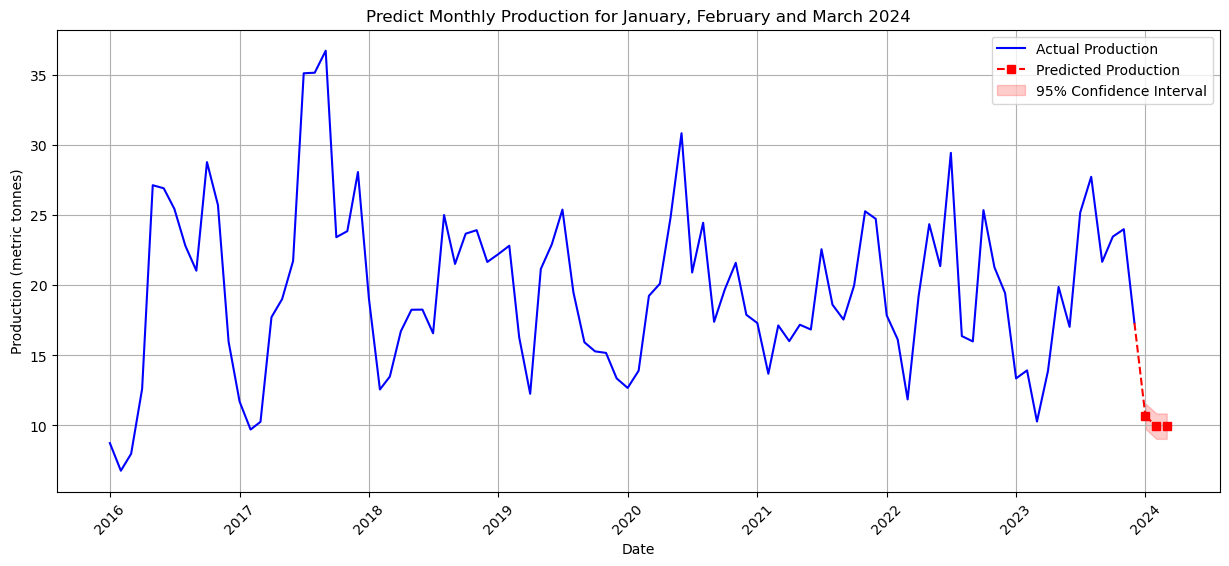

In [53]:
# Prepare input data for January - March 2024 predictions
future_dates = pd.date_range(start="2024-01-01", periods=3, freq="MS")
future_df = pd.DataFrame({"Date": future_dates})

# Extract time-based features for predictions
future_df["Year"] = future_df["Date"].dt.year
future_df["Month"] = future_df["Date"].dt.month

# Use the most recent available data for other features
latest_data = df.iloc[-1].copy()
for col in features:
    if col not in ["Year", "Month", "Month_sin", "Month_cos"]:
        future_df[col] = latest_data[col]

# Make predictions
future_df["Predicted_Production"] = best_model.predict(future_df[final_features])

# Compute residual standard deviation from training data
y_train_pred = best_model.predict(X_train)
residual_std = np.std(y_train - y_train_pred)  # Standard deviation of residuals

# Compute 95% confidence intervals
future_df["Lower_CI"] = future_df["Predicted_Production"] - 1.96 * residual_std
future_df["Upper_CI"] = future_df["Predicted_Production"] + 1.96 * residual_std

# Display predictions
print("Predicted Oil Palm Production for Jan-Mar 2024:")
print(future_df[["Date", "Predicted_Production", "Lower_CI", "Upper_CI"]])

# Plot actual production and future predictions
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Production'], label="Actual Production", color='blue')
plt.plot(future_df["Date"], future_df["Predicted_Production"], label="Predicted Production", linestyle="dashed", marker="s", color='red')

# Connect last known data point to first predicted point
plt.plot([df["Date"].iloc[-1], future_df["Date"].iloc[0]], 
         [df["Production"].iloc[-1], future_df["Predicted_Production"].iloc[0]], 
         linestyle="dashed", color="red")

# Add 95% confidence interval shading
plt.fill_between(future_df["Date"], future_df["Lower_CI"], future_df["Upper_CI"], 
                 color='red', alpha=0.2, label="95% Confidence Interval")

plt.xlabel("Date")
plt.ylabel("Production (metric tonnes)")
plt.title(f"Predict Monthly Production for January, February and March 2024")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

## [5. Conclusion](#Table-of-Contents)

### [5.1. Key Findings](#Table-of-Contents)

This study developed a machine learning model to predict monthly oil palm production using key environmental, agronomic, and historical production factors. Through model selection and hyperparameter tuning, **XGBoost** emerged as the best-performing model, achieving an **RMSE of 3.3178** on the test dataset. The results indicate that **seasonality (Month), long-term production trends (Production_lag_36, Production_rolling_36), and rainfall patterns (Rainfall_Lag_12, Rainday_rolling_24)** play significant roles in oil palm yield fluctuations. The final model provides reliable short-term forecasts for January, February, and March 2024, with confidence intervals capturing prediction uncertainty.

### [5.2. Recommendations](#Table-of-Contents)

To enhance prediction accuracy, incorporating **additional climate variables** such as temperature, humidity, and soil moisture could provide a more comprehensive understanding of yield fluctuations. Extending the forecasting horizon beyond three months using **autoregressive models** would offer valuable insights for long-term plantation planning. **Data collection improvements**, such as recording weekly instead of monthly rainfall, could refine input quality and improve predictions. Additionally, integrating **deep learning models** like LSTMs for time series forecasting may capture complex dependencies more effectively. **Regular model retraining** with updated data is also essential to adapt to changing climatic conditions and plantation management practices.

### [5.3. Limitations](#Table-of-Contents)

The model is constrained by a **small dataset** of only 132 observations, which may limit its ability to generalize to unseen production patterns. It assumes **historical trends** remain stable, which may not hold if there are abrupt environmental or operational changes. The use of **lagged features**, while essential for capturing long-term effects, reduces the effective training sample size. Furthermore, **external factors** such as market demand and labor availability, which may influence production, were not considered. Lastly, the **confidence intervals** were estimated based on residual standard deviation, which assumes normality and may not fully reflect real-world uncertainties.